# Independent Component Analysis for stock returns

## Cours: Allocation d'Actifs et Arbitrage Multi-Asset

### *IQBI Hamza & Ahmed Amine Msik*

In [83]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA

import seaborn as sns
sns.set_style("darkgrid", {"grid.color": "white"})
mpl.rcParams['figure.dpi'] = 100
params_grid = {"color": 'lightgrey', "linestyle": 'dotted', "linewidth": 0.7 }

In [84]:
xls = pd.ExcelFile('CAC.xlsx')
df_raw = pd.read_excel(xls, 'Data', parse_dates=True)
poids = pd.read_excel(xls, 'Worksheet', parse_dates=True)
df = df_raw[1:]
df = df[df['CAC Index'] > '15/01/2021']
df = df[df['CAC Index'] < '01/02/2024']
df.head()

c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:56: UserWarning: Parsing '15/01/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return self._cmp_method(other, operator.gt)


,CAC Index,Unnamed: 1,Unnamed: 2,OR FP Equity,Unnamed: 4,Unnamed: 5,DG FP Equity,Unnamed: 7,Unnamed: 8,STLAP FP Equity,...,Unnamed: 112,Unnamed: 113,ACA FP Equity,Unnamed: 115,Unnamed: 116,RI FP Equity,Unnamed: 118,Unnamed: 119,STMPA FP Equity,Unnamed: 121
5128,2021-01-18,5617.27,NaN,2021-01-18,296.9,NaN,2021-01-18,84.66,NaN,NaT,...,NaN,NaN,2021-12-27,12.504,NaN,44214,155.35,NaN,44214,33.07
5129,2021-01-19,5598.61,NaN,2021-01-19,297.1,NaN,2021-01-19,84.84,NaN,NaT,...,NaN,NaN,2021-12-28,12.550,NaN,44215,156.3,NaN,44215,32.76
5130,2021-01-20,5628.44,NaN,2021-01-20,293.6,NaN,2021-01-20,83.58,NaN,NaT,...,NaN,NaN,2021-12-29,12.568,NaN,44216,154.15,NaN,44216,33.50
5131,2021-01-21,5590.79,NaN,2021-01-21,294.6,NaN,2021-01-21,81.52,NaN,NaT,...,NaN,NaN,2021-12-30,12.604,NaN,44217,153.65,NaN,44217,33.40
5132,2021-01-22,5559.57,NaN,2021-01-22,296.3,NaN,2021-01-22,80.46,NaN,NaT,...,NaN,NaN,2021-12-31,12.550,NaN,44218,153.1,NaN,44218,32.60


In [85]:
poids

,Ticker,Nom,Poids
0,AI FP Equity,Air Liquide SA,0.0534
1,AIR FP Equity,Airbus SE,0.0476
2,ALO FP Equity,Alstom SA,0.0022
3,MT NA Equity,ArcelorMittal SA,0.0077
4,CS FP Equity,AXA SA,0.0327
5,BNP FP Equity,BNP Paribas,0.0426
6,EN FP Equity,Bouygues SA,0.0038
7,CAP FP Equity,Capgemini SE,0.0182
8,CA FP Equity,Carrefour SA,0.0055
9,SGO FP Equity,Compagnie de Saint-Gobain,0.0178


In [86]:
df.rename(columns={'CAC Index': 'Date'}, inplace=True)
df.rename(columns={'Unnamed: 1': 'CAC40'}, inplace=True)
dates = df['Date']
cols = df.columns

dfs = {}
df_cac = pd.DataFrame({'Date': df['Date'], 'CAC40': df['CAC40']})
dfs['CAC40'] = df_cac

# On crée différents DataFrames, chacune contenant les rendements d'un stock avec la date associée
to_remove = ['EDEN FP Equity', 'ENGI FP Equity', 
            'LR FP Equity', 'STLAP FP Equity', 'URW FP Equity']
poids = poids[~poids['Ticker'].isin(to_remove)]
for stock in poids['Ticker']:
    indx = df.columns.get_loc(stock)
    returns = df[cols[indx+1]]
    df_stock = pd.DataFrame({'Date': dates, stock: returns})
    df_stock.dropna(inplace=True)
    dfs[stock] = df_stock

## Exploratory Data Analysis

Text(0.5, 1.0, 'CAC40 daily prices')

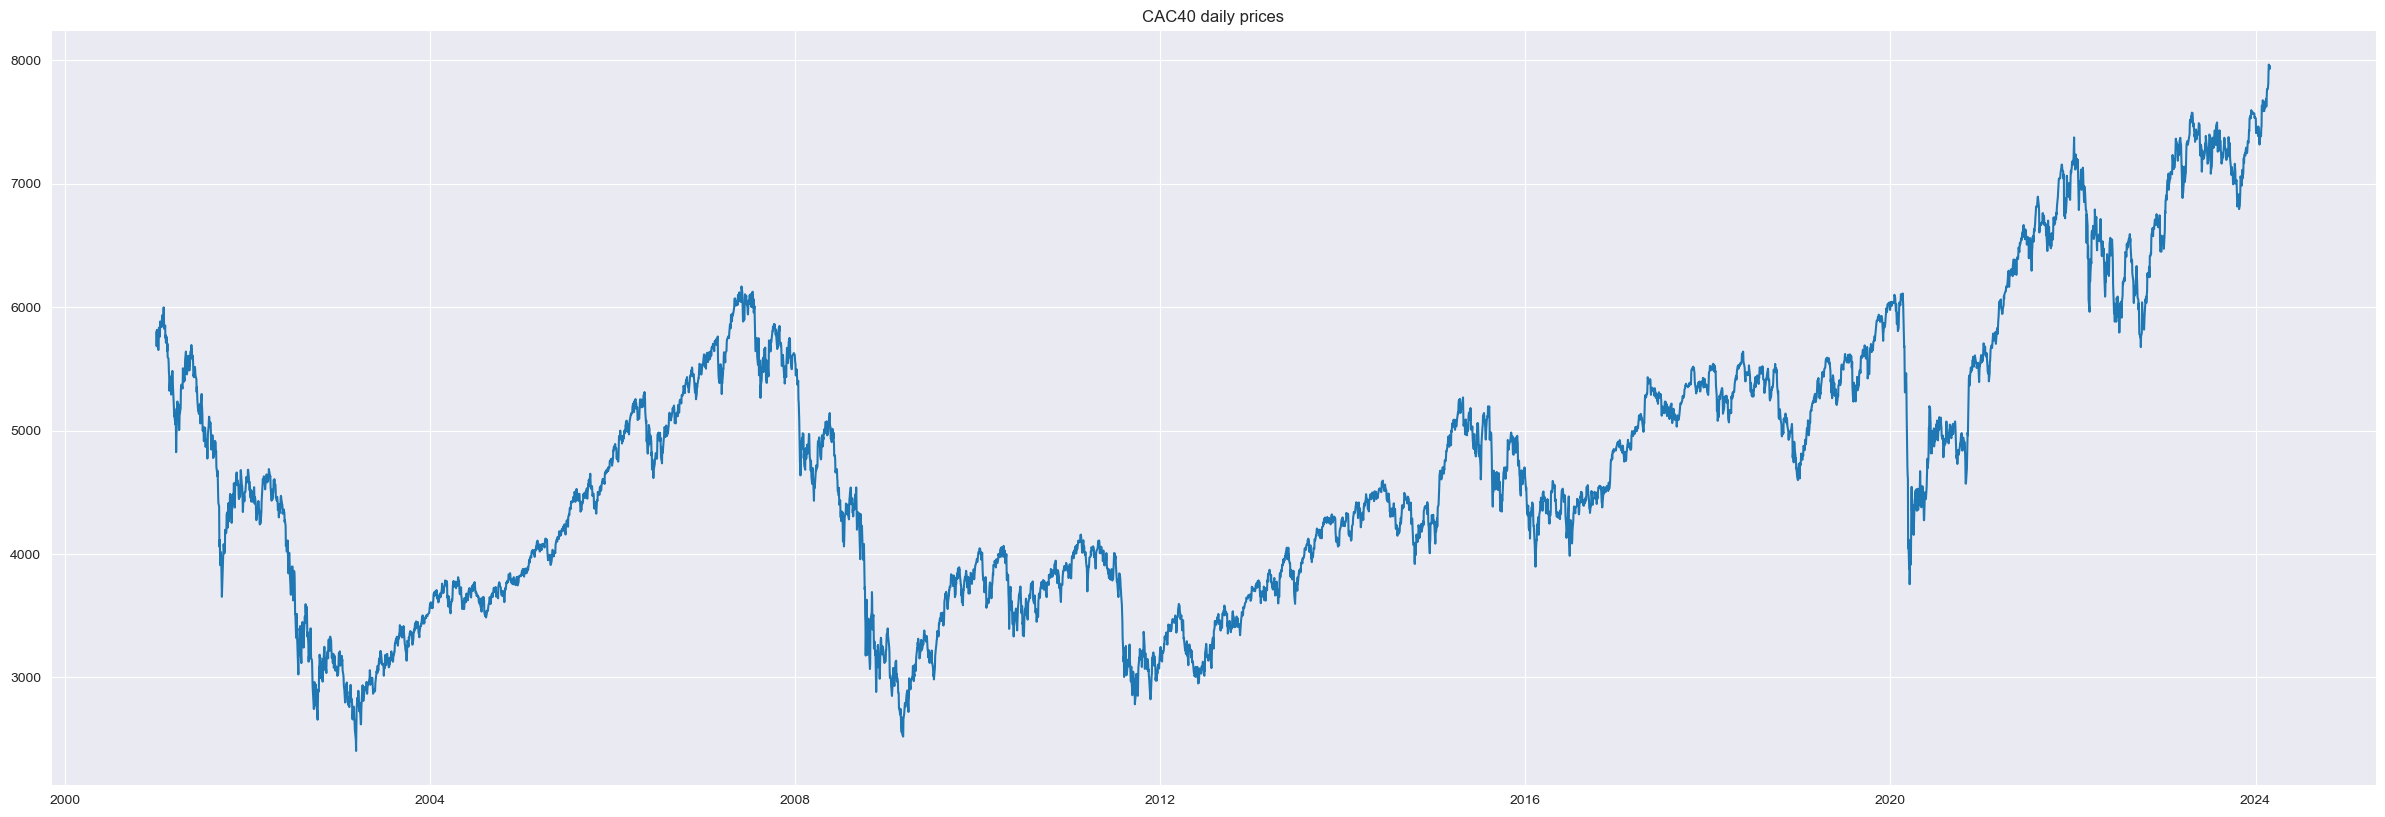

In [87]:
# plot CAC40 returns
cac_to_plot = df_raw['Unnamed: 1']
dates_cac_to_plot = df_raw['CAC Index']
fig = plt.figure(figsize = (30, 10))  
ax = fig.add_subplot(111)
plt.plot(dates_cac_to_plot, cac_to_plot)
plt.title('CAC40 daily prices')

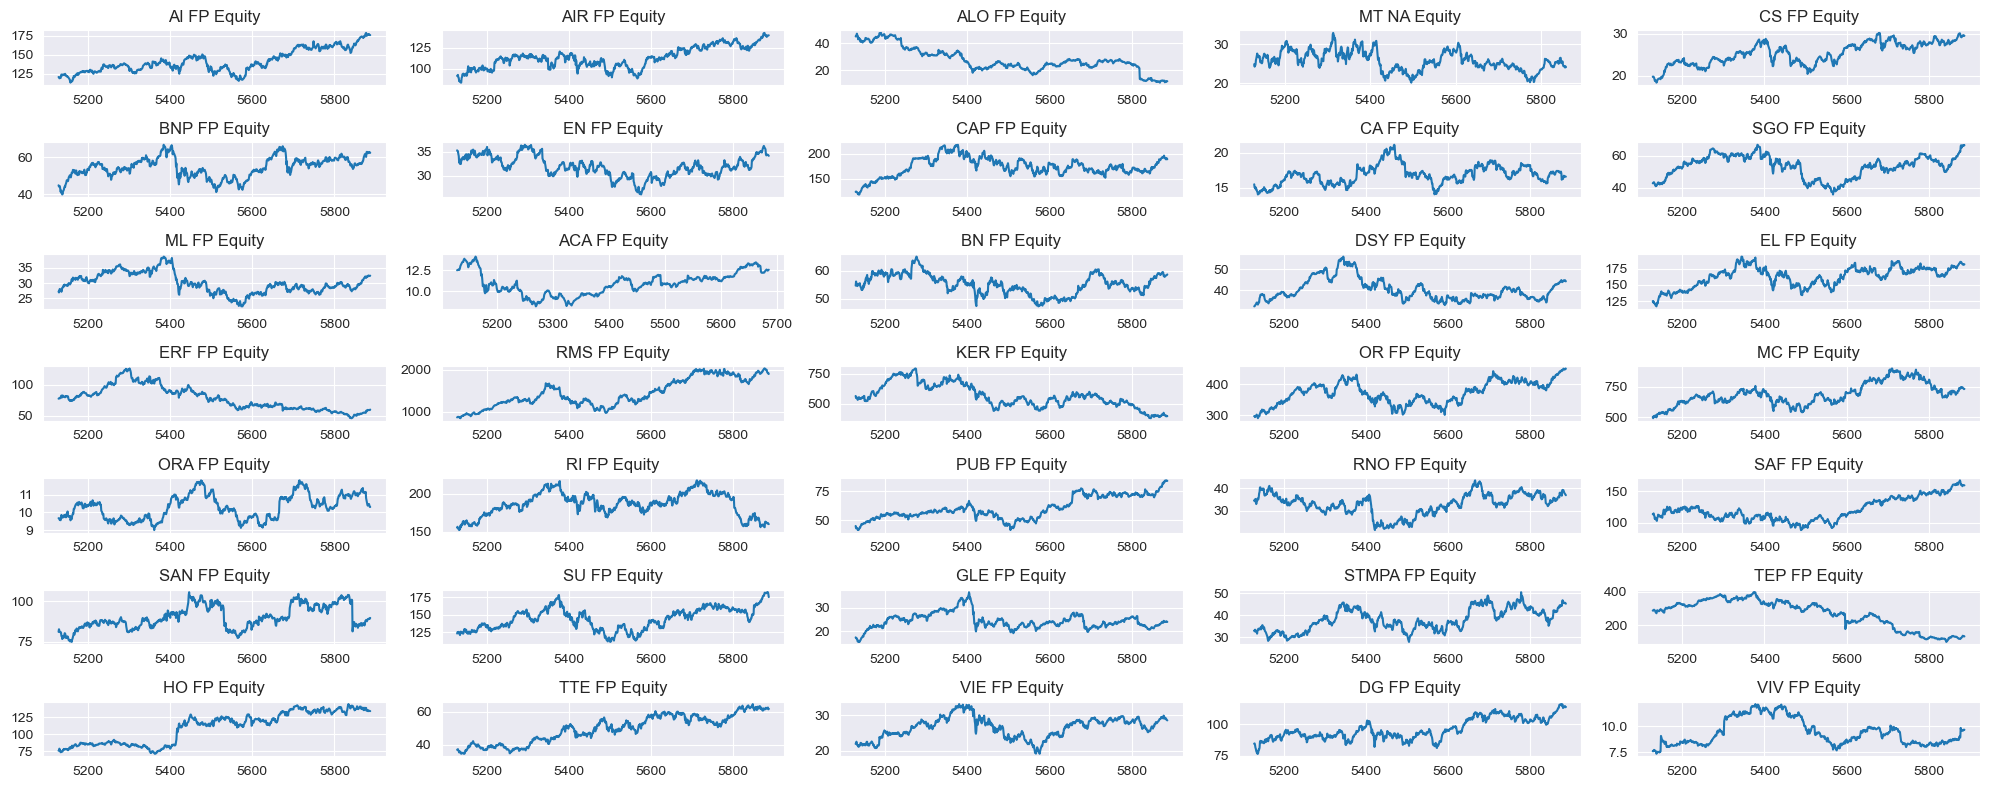

In [88]:
stocks = poids['Ticker']
f = plt.figure(figsize=(20, 10))
for i, stock in enumerate(stocks) :
    plt.subplot(9, 5, i + 1)
    stock_data = dfs[stock]
    plt.plot(stock_data[stock])
    plt.title(stock)

plt.tight_layout()
plt.show()

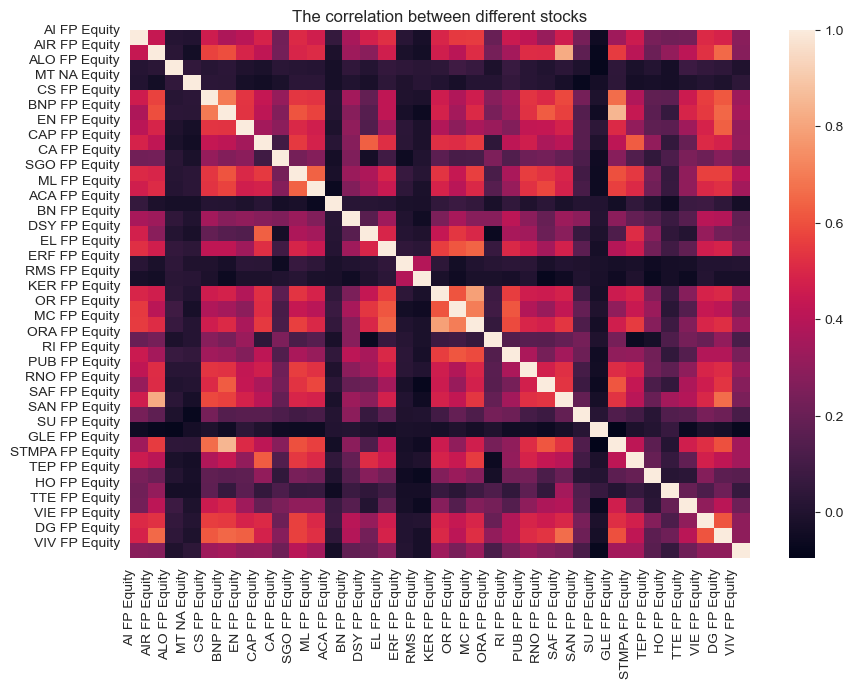

In [89]:
plt.figure(figsize=(10, 7))
sns.heatmap(pd.concat([dfs[stock][stock].pct_change() for stock in stocks], axis=1).corr())
plt.yticks(range(len(stocks)), stocks)
plt.xticks(range(len(stocks)), stocks)
plt.title("The correlation between different stocks")
plt.show()

## Independent Component Analysis (ICA)

In [90]:
# Construction of the dataframe containing the prices of each stock
# and the CAC40 index

prices = pd.DataFrame()
for key, df in dfs.items():
    if prices.empty:
        prices = df
    else:
        prices = prices.merge(df, on='Date', how='outer')
    
prices.dropna(inplace=True)
prices.head()

,Date,CAC40,AI FP Equity,AIR FP Equity,ALO FP Equity,MT NA Equity,CS FP Equity,BNP FP Equity,EN FP Equity,CAP FP Equity,...,SAN FP Equity,SU FP Equity,GLE FP Equity,STMPA FP Equity,TEP FP Equity,HO FP Equity,TTE FP Equity,VIE FP Equity,DG FP Equity,VIV FP Equity
0,2021-01-18,5617.27,120.8182,91.19,45.02,24.885,19.734,44.805,35.27,124.85,...,81.1876,123.2,17.4,33.07,286.2,75.46,36.980,21.906,84.66,7.6113
1,2021-01-19,5598.61,120.3182,91.3,44.86,24.25,19.650,44.11,35.09,125.40,...,82.7789,125.15,16.984,32.76,285.6,75.6,37.150,22.3206,84.84,7.6026
2,2021-01-20,5628.44,119.0909,92.41,45.99,24.665,19.716,44.42,35.08,124.50,...,81.9037,125.35,17.084,33.50,288.2,78.5,37.345,22.5423,83.58,7.6753
3,2021-01-21,5590.79,119.2273,89.36,47.00,24.695,19.518,44.34,34.5,124.30,...,80.9787,124.7,16.898,33.40,291.4,76.58,36.475,21.9831,81.52,7.7363
4,2021-01-22,5559.57,120.0455,88.83,45.60,25.91,19.212,43.085,34.09,123.40,...,81.0185,125.6,16.34,32.60,289.8,75.5,36.220,21.5492,80.46,7.7218


In [91]:
returns = prices.apply(lambda x: x-x.shift(1) if x.name != 'Date' else x)
returns.dropna(inplace=True)
returns.head()

,Date,CAC40,AI FP Equity,AIR FP Equity,ALO FP Equity,MT NA Equity,CS FP Equity,BNP FP Equity,EN FP Equity,CAP FP Equity,...,SAN FP Equity,SU FP Equity,GLE FP Equity,STMPA FP Equity,TEP FP Equity,HO FP Equity,TTE FP Equity,VIE FP Equity,DG FP Equity,VIV FP Equity
1,2021-01-19,-18.66,-0.5000,0.11,-0.16,-0.635,-0.084,-0.695,-0.18,0.55,...,1.5913,1.95,-0.416,-0.31,-0.6,0.14,0.170,0.4146,0.18,-0.0087
2,2021-01-20,29.83,-1.2273,1.11,1.13,0.415,0.066,0.31,-0.01,-0.90,...,-0.8752,0.2,0.1,0.74,2.6,2.9,0.195,0.2217,-1.26,0.0727
3,2021-01-21,-37.65,0.1364,-3.05,1.01,0.03,-0.198,-0.08,-0.58,-0.20,...,-0.925,-0.65,-0.186,-0.10,3.2,-1.92,-0.870,-0.5592,-2.06,0.0610
4,2021-01-22,-31.22,0.8182,-0.53,-1.40,1.215,-0.306,-1.255,-0.41,-0.90,...,0.0398,0.9,-0.558,-0.80,-1.6,-1.08,-0.255,-0.4339,-1.06,-0.0145
5,2021-01-25,-87.21,-0.5910,-3.96,-0.16,0.465,-0.442,-1.855,-1.35,-2.20,...,0.0398,-2.5,-0.724,0.09,-3.2,-2.3,-0.870,0.0097,-1.74,-0.0814


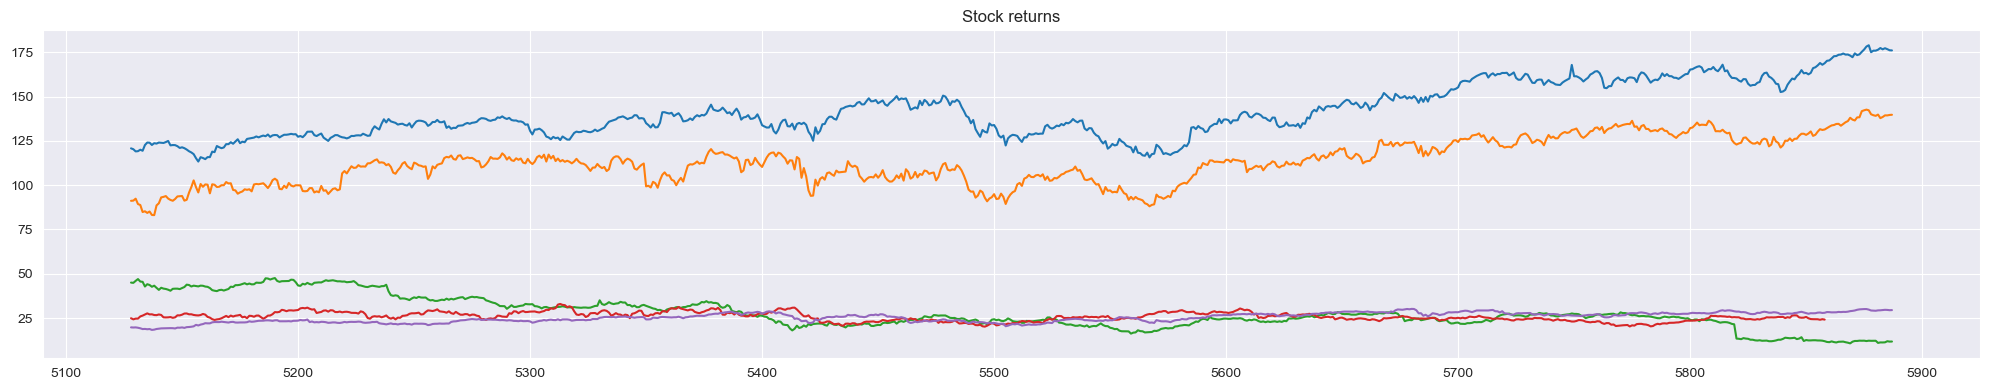

In [92]:
f = plt.figure(figsize=(20, 4))
for i, stock in enumerate(stocks[:5]) :
    stock_data = dfs[stock]
    plt.plot(stock_data[stock])
    if i == 0:
        plt.title("Stock returns")
    
plt.tight_layout()
plt.show()

In [93]:
ica = FastICA(n_components=min(len(returns.columns),10), 
              random_state=0)
ica_components = ica.fit_transform(returns.drop('Date', axis=1))
ica_df = pd.DataFrame(ica_components, index=returns.index,
                      columns=[f'ICA_{i+1}' for i in range(ica_components.shape[1])])
ica_df

C:\Users\IQBI Hamza\AppData\Roaming\Python\Python39\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


,ICA_1,ICA_2,ICA_3,ICA_4,ICA_5,ICA_6,ICA_7,ICA_8,ICA_9,ICA_10
1,0.013126,-0.014630,0.013322,-0.006450,0.019163,0.018194,-0.085636,0.015927,-0.030829,-0.009012
2,-0.060501,0.001159,-0.062102,0.033374,0.004104,0.004282,0.029116,-0.095307,0.034938,-0.001092
3,0.011216,0.015989,0.073218,0.012407,-0.028796,-0.019038,-0.017744,-0.037844,-0.001551,-0.002967
4,0.009542,0.023855,0.008398,-0.016787,0.000713,-0.026895,-0.026853,-0.055406,-0.022284,-0.000634
5,0.044668,0.066155,0.069802,-0.027476,-0.036911,-0.034769,-0.018937,0.010738,-0.013521,0.009107
...,...,...,...,...,...,...,...,...,...,...
554,-0.022088,0.024319,-0.007157,-0.019219,0.035921,-0.050350,0.016284,-0.054841,-0.084497,0.015703
555,0.046782,0.215347,0.038535,-0.013561,-0.070974,-0.025169,-0.030171,0.016638,0.041841,0.004700
556,0.005009,-0.096650,-0.105102,0.010730,0.034531,-0.030173,0.008936,-0.033910,-0.050063,0.031328
557,0.027075,0.203007,0.085183,0.021023,0.070297,0.036837,-0.018130,-0.004815,0.030253,0.004955


Visualisation of the Independent Components:


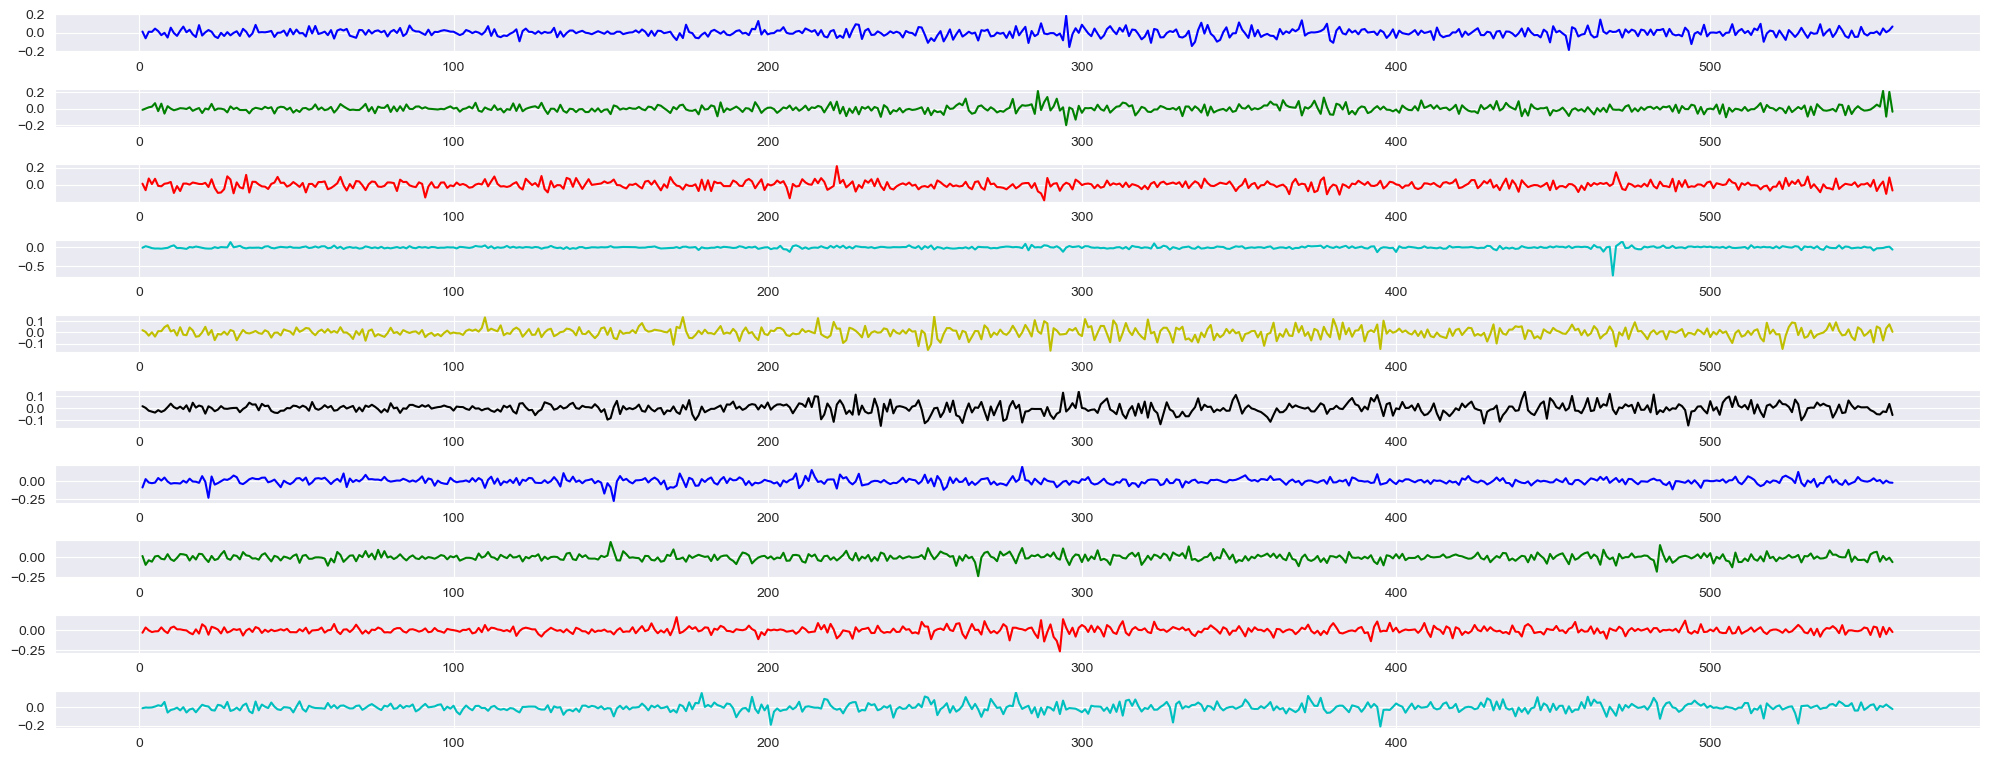

In [94]:
colors = ['b', 'g', 'r', 'c', 'y', 'k']
f = plt.figure(figsize=(20, 15))
for i in range(ica_df.shape[1]):
    plt.subplot(20, 1, i + 1)
    plt.plot(ica_df.iloc[:, i], color = colors[i%6])

print("Visualisation of the Independent Components:")
plt.tight_layout()
plt.show()

Returns reconstruction for 10 dominant ICs:


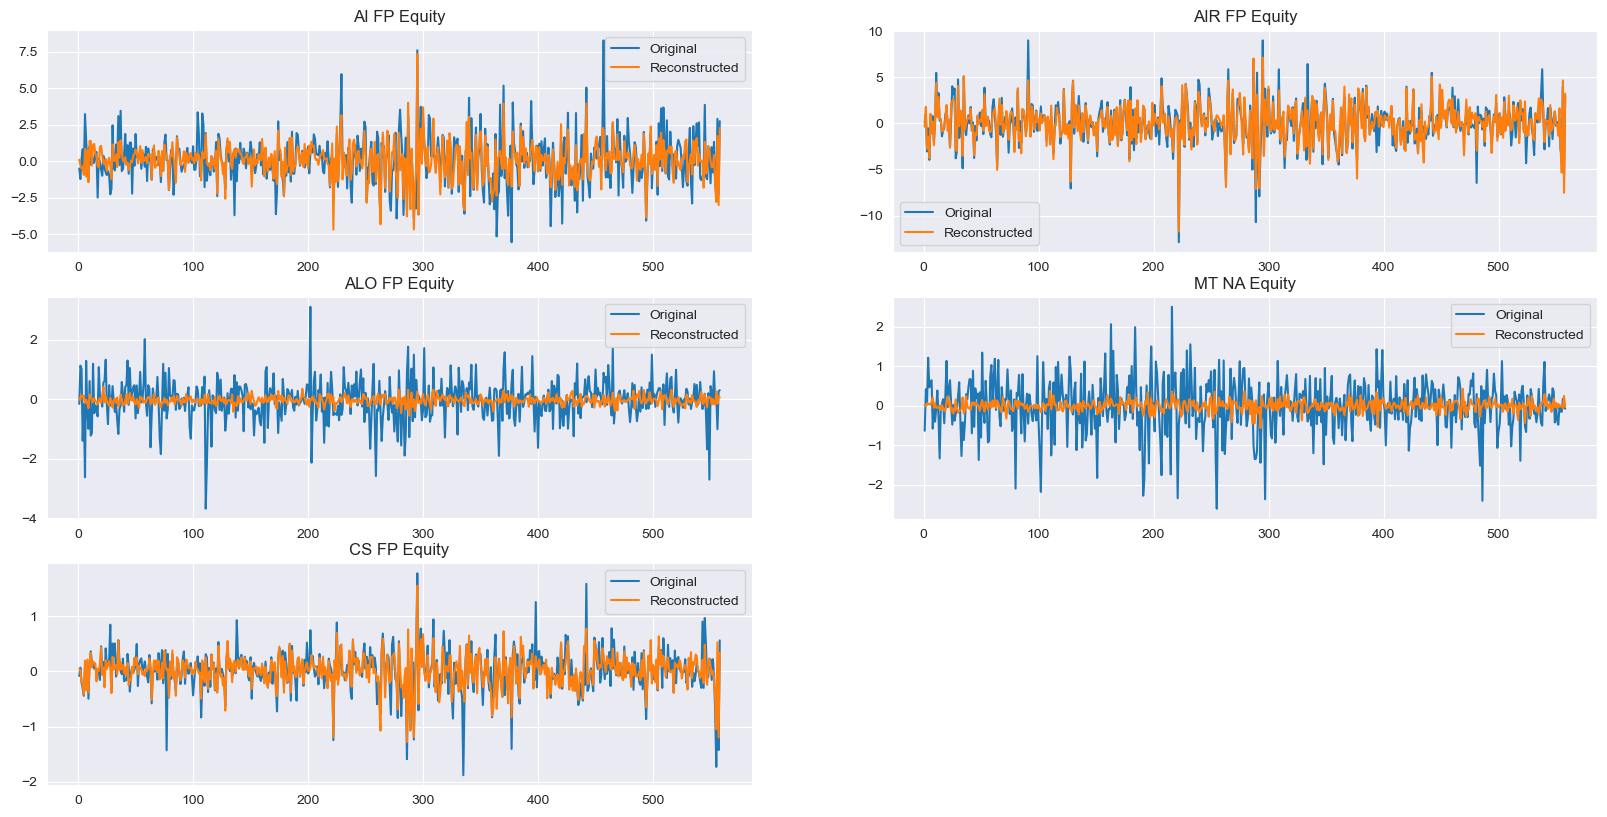

Text(0.5, 1.0, 'CAC40')

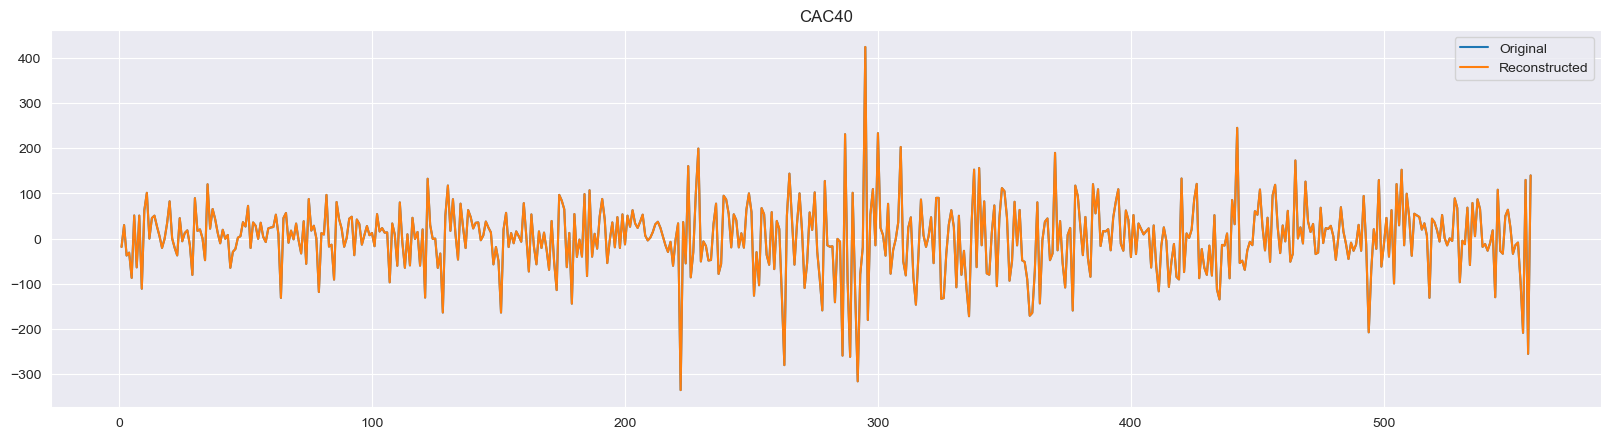

In [95]:
# reconstruct stock prices from ICs
reconstructed = ica.inverse_transform(ica_components)
reconstructed_df = pd.DataFrame(reconstructed, index=returns.index, columns=returns.columns[1:])

print("Returns reconstruction for 10 dominant ICs:")

# plot the reconstructed stock prices
f = plt.figure(figsize=(20, 10))
for i, stock in enumerate(stocks[:5]) :
    plt.subplot(3, 2, i + 1)
    plt.plot(returns[stock], label='Original')
    plt.plot(reconstructed_df[stock], label='Reconstructed')
    plt.title(stock)
    plt.legend()
plt.show()

# plot the original and reconstructed CAC40 index
plt.figure(figsize=(20, 5))
plt.plot(returns['CAC40'], label='Original')
plt.plot(reconstructed_df['CAC40'], label='Reconstructed')
plt.legend()
plt.title('CAC40')

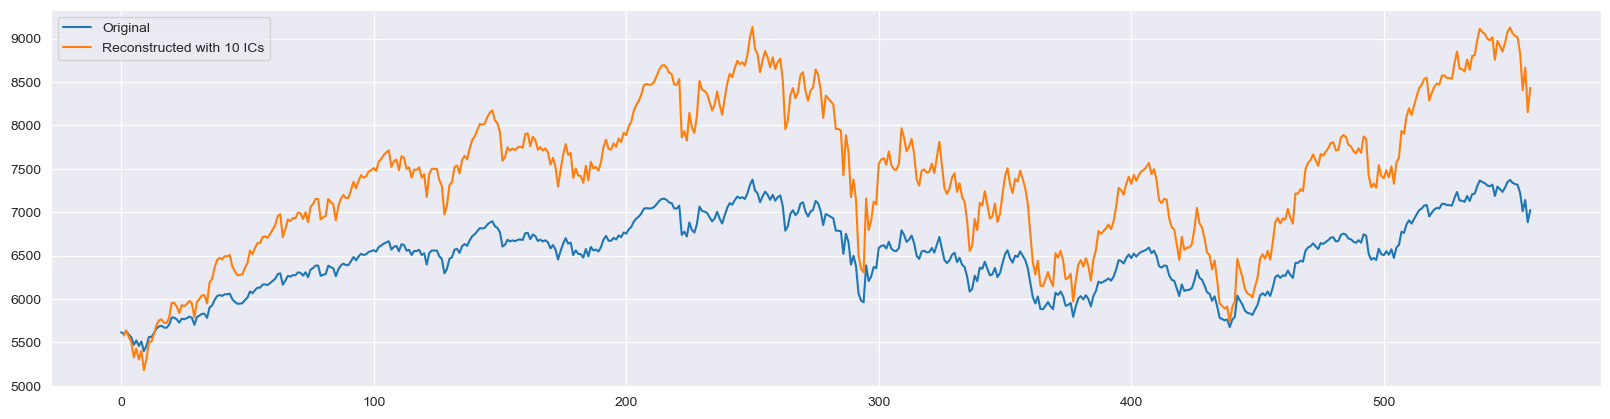

In [96]:
ica_prices = reconstructed_df.cumsum().add(prices, axis='columns')
ica_prices['Date'] = returns['Date']

# plot the original and reconstructed CAC40 index
plt.figure(figsize=(20, 5))
plt.plot(prices['CAC40'], label='Original')
plt.plot(ica_prices['CAC40'], label='Reconstructed with 10 ICs')
plt.legend()

## Comparison with PCA

In [97]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(returns.drop('Date', axis=1))
pca_df = pd.DataFrame(pca_components, index=returns.index,
                      columns=[f'PCA_{i+1}' for i in range(pca_components.shape[1])])

reconstructed_pca = pca.inverse_transform(pca_components)
reconstructed_pca_df = pd.DataFrame(reconstructed_pca, index=returns.index, columns=returns.columns[1:])

Visualisation of the Principal Components:


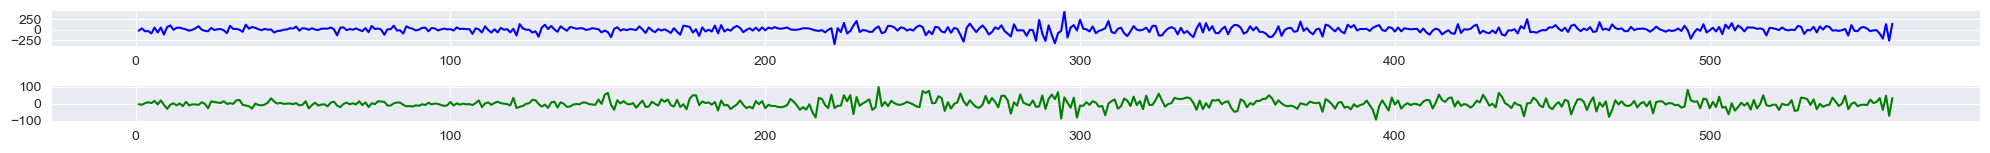

In [98]:
colors = ['b', 'g', 'r', 'c', 'y']
f = plt.figure(figsize=(20, 15))
for i in range(pca_df.shape[1]):
    plt.subplot(20, 1, i + 1)
    plt.plot(pca_df.iloc[:, i], color = colors[i%5])

print("Visualisation of the Principal Components:")
plt.tight_layout()
plt.show()

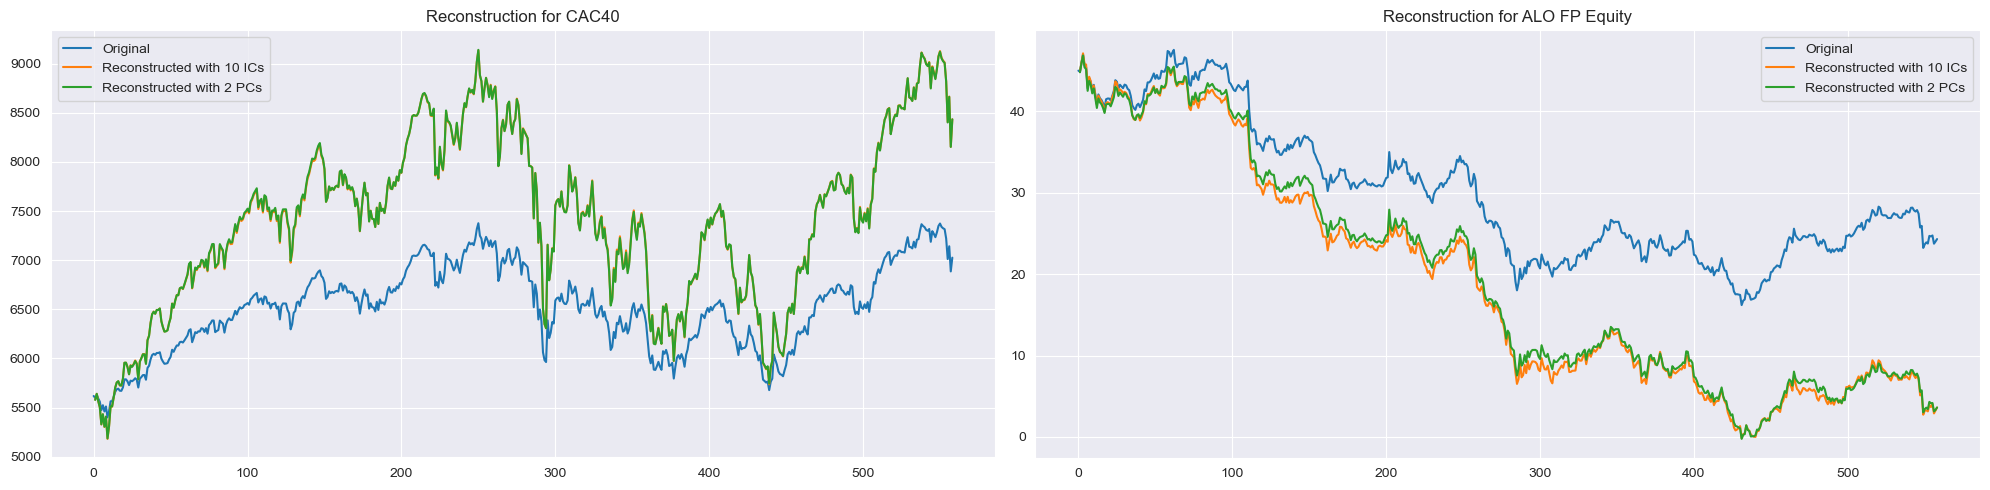

In [99]:
pca_prices = reconstructed_pca_df.cumsum().add(prices, axis='columns')
pca_prices['Date'] = returns['Date']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

# Plot for CAC40
axes[0].plot(prices['CAC40'], label='Original')
axes[0].plot(ica_prices['CAC40'], label='Reconstructed with 10 ICs')
axes[0].plot(pca_prices['CAC40'], label='Reconstructed with 2 PCs')
axes[0].set_title("Reconstruction for CAC40")
axes[0].legend()

# Plot for ALO FP Equity
axes[1].plot(prices['ALO FP Equity'], label='Original')
axes[1].plot(ica_prices['ALO FP Equity'], label='Reconstructed with 10 ICs')
axes[1].plot(pca_prices['ALO FP Equity'], label='Reconstructed with 2 PCs')
axes[1].set_title("Reconstruction for ALO FP Equity")
axes[1].legend()

plt.tight_layout()
plt.show()
